In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
 
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.3),  # Randomly convert to grayscale
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),  # Important for day/night variation
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
 
train_dataset = datasets.ImageFolder(
    root='train',
 
 
 
    transform=train_transform
)
 
val_dataset = datasets.ImageFolder(
    root='test',
    transform=train_transform
)
 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [79]:
import torch.nn as nn
import torch.nn.functional as F
 
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
       
        self.fc1 = nn.Linear(32 * (128//4) * (128//4), 64)
        self.fc2 = nn.Linear(64, num_classes)
   
    def forward(self, x):
        print(x.shape)
        x = F.relu(self.conv1(x))
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        x = F.relu(self.conv2(x))
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = self.fc2(x)
        print(x.shape)
        return x

In [80]:
import torch.optim as optim

model = SimpleCNN(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Early stopping parameters
best_val_loss = float('inf')
patience = 10
counter = 0
best_model_path = 'best_model.pth'

epochs = 100
for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
   
    train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_loss = val_running_loss / len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with validation loss: {best_val_loss:.4f}")
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} out of {patience}")
        if counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model after training
model.load_state_dict(torch.load(best_model_path))
print("Loaded best model for evaluation")


torch.Size([30, 3, 128, 128])
torch.Size([30, 16, 128, 128])
torch.Size([30, 16, 64, 64])
torch.Size([30, 32, 64, 64])
torch.Size([30, 32, 32, 32])
torch.Size([30, 32768])
torch.Size([30, 64])
torch.Size([30, 3])
Epoch [1/100], Training Loss: 1.1065
torch.Size([10, 3, 128, 128])
torch.Size([10, 16, 128, 128])
torch.Size([10, 16, 64, 64])
torch.Size([10, 32, 64, 64])
torch.Size([10, 32, 32, 32])
torch.Size([10, 32768])
torch.Size([10, 64])
torch.Size([10, 3])
Validation Loss: 1.4039
Saved best model with validation loss: 1.4039
torch.Size([30, 3, 128, 128])
torch.Size([30, 16, 128, 128])
torch.Size([30, 16, 64, 64])
torch.Size([30, 32, 64, 64])
torch.Size([30, 32, 32, 32])
torch.Size([30, 32768])
torch.Size([30, 64])
torch.Size([30, 3])
Epoch [2/100], Training Loss: 2.5487
torch.Size([10, 3, 128, 128])
torch.Size([10, 16, 128, 128])
torch.Size([10, 16, 64, 64])
torch.Size([10, 32, 64, 64])
torch.Size([10, 32, 32, 32])
torch.Size([10, 32768])
torch.Size([10, 64])
torch.Size([10, 3])
Vali

In [81]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

torch.Size([10, 3, 128, 128])
torch.Size([10, 16, 128, 128])
torch.Size([10, 16, 64, 64])
torch.Size([10, 32, 64, 64])
torch.Size([10, 32, 32, 32])
torch.Size([10, 32768])
torch.Size([10, 64])
torch.Size([10, 3])
Validation Accuracy: 70.00%


torch.Size([1, 3, 128, 128])
torch.Size([1, 16, 128, 128])
torch.Size([1, 16, 64, 64])
torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32768])
torch.Size([1, 64])
torch.Size([1, 3])


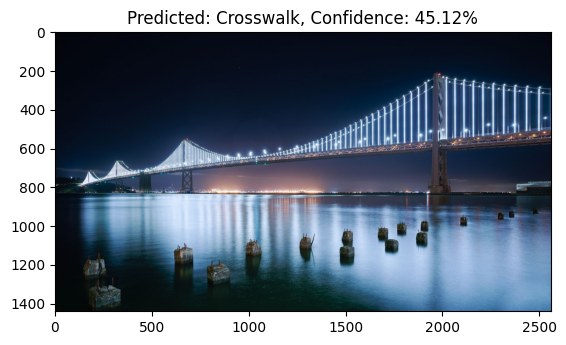

In [85]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
# Load and transform the external image
image_path = r"D:/Course/Ai concept CSX4201/Preparation/Final Dataset - Copy/dataset/test/Bridge/3.jpg"
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
image = transform(image).unsqueeze(0)  # Add batch dimension
 
# Assume 'model' is your trained SimpleCNN model
model.eval()  # Set the model to evaluation mode
 
# Predict
with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)  # Apply softmax to convert to probabilities
    max_prob, predicted = torch.max(probabilities, 1)  # Get the prediction and its confidence
 
# Load the image for displaying
image_display = Image.open(image_path)
plt.imshow(image_display)
predicted_class = val_dataset.classes[predicted[0]]
plt.title(f'Predicted: {predicted_class}, Confidence: {max_prob.item()*100:.2f}%')
plt.show()

torch.Size([1, 3, 128, 128])
torch.Size([1, 16, 128, 128])
torch.Size([1, 16, 64, 64])
torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32768])
torch.Size([1, 64])
torch.Size([1, 3])


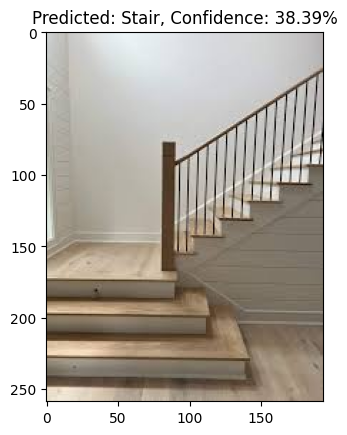

In [83]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
# Load and transform the external image
image_path = r"D:/Course/Ai concept CSX4201/Preparation/Final Dataset - Copy/dataset/test/Stair/2.jpg"
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
image = transform(image).unsqueeze(0)  # Add batch dimension
 
# Assume 'model' is your trained SimpleCNN model
model.eval()  # Set the model to evaluation mode
 
# Predict
with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)  # Apply softmax to convert to probabilities
    max_prob, predicted = torch.max(probabilities, 1)  # Get the prediction and its confidence
 
# Load the image for displaying
image_display = Image.open(image_path)
plt.imshow(image_display)
predicted_class = val_dataset.classes[predicted[0]]
plt.title(f'Predicted: {predicted_class}, Confidence: {max_prob.item()*100:.2f}%')
plt.show()

torch.Size([1, 3, 128, 128])
torch.Size([1, 16, 128, 128])
torch.Size([1, 16, 64, 64])
torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32768])
torch.Size([1, 64])
torch.Size([1, 3])


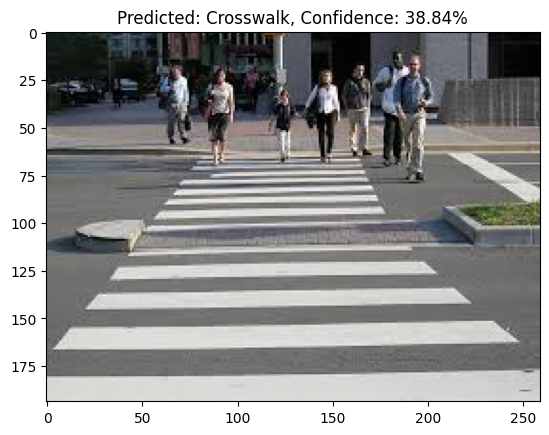

In [84]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
# Load and transform the external image
image_path = r"D:\Course\Ai concept CSX4201\Preparation\Final Dataset - Copy\dataset\test\Crosswalk\1.jpg"
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
image = transform(image).unsqueeze(0)  # Add batch dimension
 
# Assume 'model' is your trained SimpleCNN model
model.eval()  # Set the model to evaluation mode
 
# Predict
with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)  # Apply softmax to convert to probabilities
    max_prob, predicted = torch.max(probabilities, 1)  # Get the prediction and its confidence
 
# Load the image for displaying
image_display = Image.open(image_path)
plt.imshow(image_display)
predicted_class = val_dataset.classes[predicted[0]]
plt.title(f'Predicted: {predicted_class}, Confidence: {max_prob.item()*100:.2f}%')
plt.show()